In [1]:
## load necessary modules
import argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from utils.tools import *
from utils.losses import *
from models.mnist import *

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

In [2]:
## Training
# torch.manual_seed(random_seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # check if gpu is available

## load datasets
# train_gen, dev_gen, test_gen = load(batch_size, batch_size)
# data = inf_train_gen_mnist(train_gen)
transform    = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_gen    = dsets.MNIST(root="./datasets",train=True, transform=transform, download=True)
test_gen     = dsets.MNIST(root="./datasets",train=False, transform=transform, download=True)
# train_loader = DataLoader(train_gen, batch_size=batch_size, shuffle=True)
# test_loader  = DataLoader(test_gen, batch_size=batch_size, shuffle=True)


## initial empty lists for training progress
# primal_loss_GI = []
# dual_loss_GI = []
# primal_loss = []
# dual_loss = []
# primal_loss_z = []
# loss_mmd = []
# gp = []
# re = []

In [3]:
## hyper-parameters
n_rep = 1
random_seed = 2020
epochs1 = 40
epochs2 = 40
std = 0.5
learning_rate = 5e-4
weight_decay = 0.01
batch_size = 250
z_dim = 5
# lambda_mmd = 10.0
lambda_gp = 0.1
lambda_power = 1.0
present_label = list(range(10))
missing_label = []
all_label     = present_label + missing_label
classes       = train_gen.classes

In [4]:
# ************************
# *** DPI-RG Algorithm ***
# ************************

cover_accs = []
avg_counts = []

# for rep in range(n_rep):
T_trains = []
for lab in present_label:
    ## initialize models
    netI = I_MNIST(num_classes=z_dim)
    netG = G_MNIST(nz=z_dim)
    netD = D_MNIST(nz=z_dim, power = 5)
    netI = netI.to(device)
    netG = netG.to(device)
    netD = netD.to(device)
    netI = nn.DataParallel(netI)
    netG = nn.DataParallel(netG)
    netD = nn.DataParallel(netD)
    # model_save_file = 'mnist_param/' + 'class' + str(lab) + '.pt'
    # netI.load_state_dict(torch.load(model_save_file))

    ## set up optimizers
    optim_I = optim.Adam(netI.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optim_G = optim.Adam(netG.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optim_D = optim.Adam(netD.parameters(), lr=learning_rate * 5, betas=(0.5, 0.999), 
                         weight_decay=weight_decay)
    ## filter data for each label and train them respectively
    idxs = torch.where(train_gen.targets == lab)[0] 
    train_data = torch.utils.data.Subset(train_gen, idxs)
    train_loader  = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    ## train for the first time
    train_al(netI, netG, netD, optim_I, optim_G, optim_D,
             train_gen, train_loader, batch_size, 0, epochs1, 
             z_dim, device, lab, present_label, all_label, 
             lambda_gp, lambda_power)

    ## find out fake_zs
    fake_zs = []
    with torch.no_grad(): 
        for i, batch in enumerate(train_loader):
            x, _ = batch
            fake_z = netI(x.to(device))
            fake_zs.append(fake_z)
    fake_zs = torch.cat(fake_zs)
    ## get the empirical distribution for each label
    T_train = torch.sqrt(torch.sum(fake_zs ** 2, dim=1) + 1)

    ## get powers to determine new sample sizes
    powers = []
    for cur_lab in present_label:    
        if cur_lab != lab:
            # fake_Cs for this class
            if torch.is_tensor(train_gen.targets):
                idxs3 = torch.where(train_gen.targets == cur_lab)[0] 
            else:
                idxs3 = torch.where(torch.Tensor(train_gen.targets) == cur_lab)[0] 
            train_data3 = torch.utils.data.Subset(train_gen, idxs3)
            train_loader3  = DataLoader(train_data3, batch_size=batch_size, shuffle=False)
            p_vals = torch.zeros(len(idxs3)) 
            fake_zs = torch.zeros(len(idxs3))
            em_len = len(T_train)

            for i, batch in enumerate(train_loader3):
                x, _ = batch
                fake_z = netI(x.to(device))
                T_batch = torch.sqrt(torch.sum(fake_z ** 2, dim=1) + 1)

                # compute p-value for each sample
                for j in range(len(fake_z)):
                    p1 = torch.sum(T_train > T_batch[j]) / em_len
                    p = p1
                    # calculate the p-value and put it in the corresponding list
                    p_vals[i * batch_size + j] = p.item()
            powers.append(np.sum(np.array(p_vals) <= 0.05) / len(idxs3))
            
    sample_sizes = max(powers) - powers + 0.05
    sample_sizes = (sample_sizes / sum(sample_sizes) * len(idxs3)).astype(int)
    ## train for the second time according to the calculated sample sizes
    train_al(netI, netG, netD, optim_I, optim_G, optim_D,
             train_gen, train_loader, batch_size, epochs1, epochs2, 
             z_dim, device, lab, present_label, all_label, 
             lambda_gp, lambda_power, sample_sizes)
    
    ## find out fake_zs
    fake_zs = []
    with torch.no_grad(): 
        for i, batch in enumerate(train_loader):
            x, _ = batch
            fake_z = netI(x.to(device))
            fake_zs.append(fake_z)
    fake_zs = torch.cat(fake_zs)
    ## get the empirical distribution for each label
    T_train = torch.sqrt(torch.sum(fake_zs ** 2, dim=1) + 1)
    T_trains.append(T_train)

    ## save net and graphs for each label
    model_save_file = 'mnist_param/' + 'class' + str(lab) + '.pt'
    torch.save(netI.state_dict(), model_save_file)
    del netI
    print('Class', lab)

Class 0
Class 1
Class 2
Class 3
Class 4
Class 5
Class 6
Class 7
Class 8
Class 9


In [5]:
# print(primal_loss_GI)
# print(dual_loss_GI)
# print(loss_mmd)
# print(gp)
# print(re)

In [6]:
all_p_vals  = []
all_fake_zs = []

for lab in all_label:    
    if torch.is_tensor(test_gen.targets):
        idxs2 = torch.where(test_gen.targets == lab)[0] 
    else:
        idxs2 = torch.where(torch.Tensor(test_gen.targets) == lab)[0] 
    test_data = torch.utils.data.Subset(test_gen, idxs2)
    test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # p_vals and fake_zs store p-values, fake_zs for the current iteration
    fake_zs = torch.zeros(len(present_label), len(idxs2))
    p_vals = torch.zeros(len(present_label), len(idxs2)) 

    for pidx in range(len(present_label)):
        T_train = T_trains[pidx]
        em_len = len(T_train)
        netI = I_MNIST(num_classes=z_dim)
        netI = netI.to(device)
        netI = torch.nn.DataParallel(netI)
        model_save_file = 'mnist_param/' + 'class' + str(present_label[pidx]) + '.pt'
        netI.load_state_dict(torch.load(model_save_file))

        for i, batch in enumerate(test_loader):
            images, y = batch
            x = images.view(-1, 784).to(device)
            fake_z = netI(x)
            T_batch = torch.sqrt(torch.sum(torch.square(fake_z), 1) + 1) 
            ## compute p-value for each sample
            for j in range(len(fake_z)):
                p1 = torch.sum(T_train > T_batch[j]) / em_len
                p = p1
                # calculate the p-value and put it in the corresponding list
                p_vals[pidx, i * batch_size + j] = p.item()

    all_p_vals.append(np.array(p_vals))
    ## concatenate torch data
    all_fake_zs.append(np.array(fake_zs))
    # print('Finished Label {}'.format(lab))

----------------------------------------------------------------------------------------------------------------------------------
                                                            p-values
----------------------------------------------------------------------------------------------------------------------------------


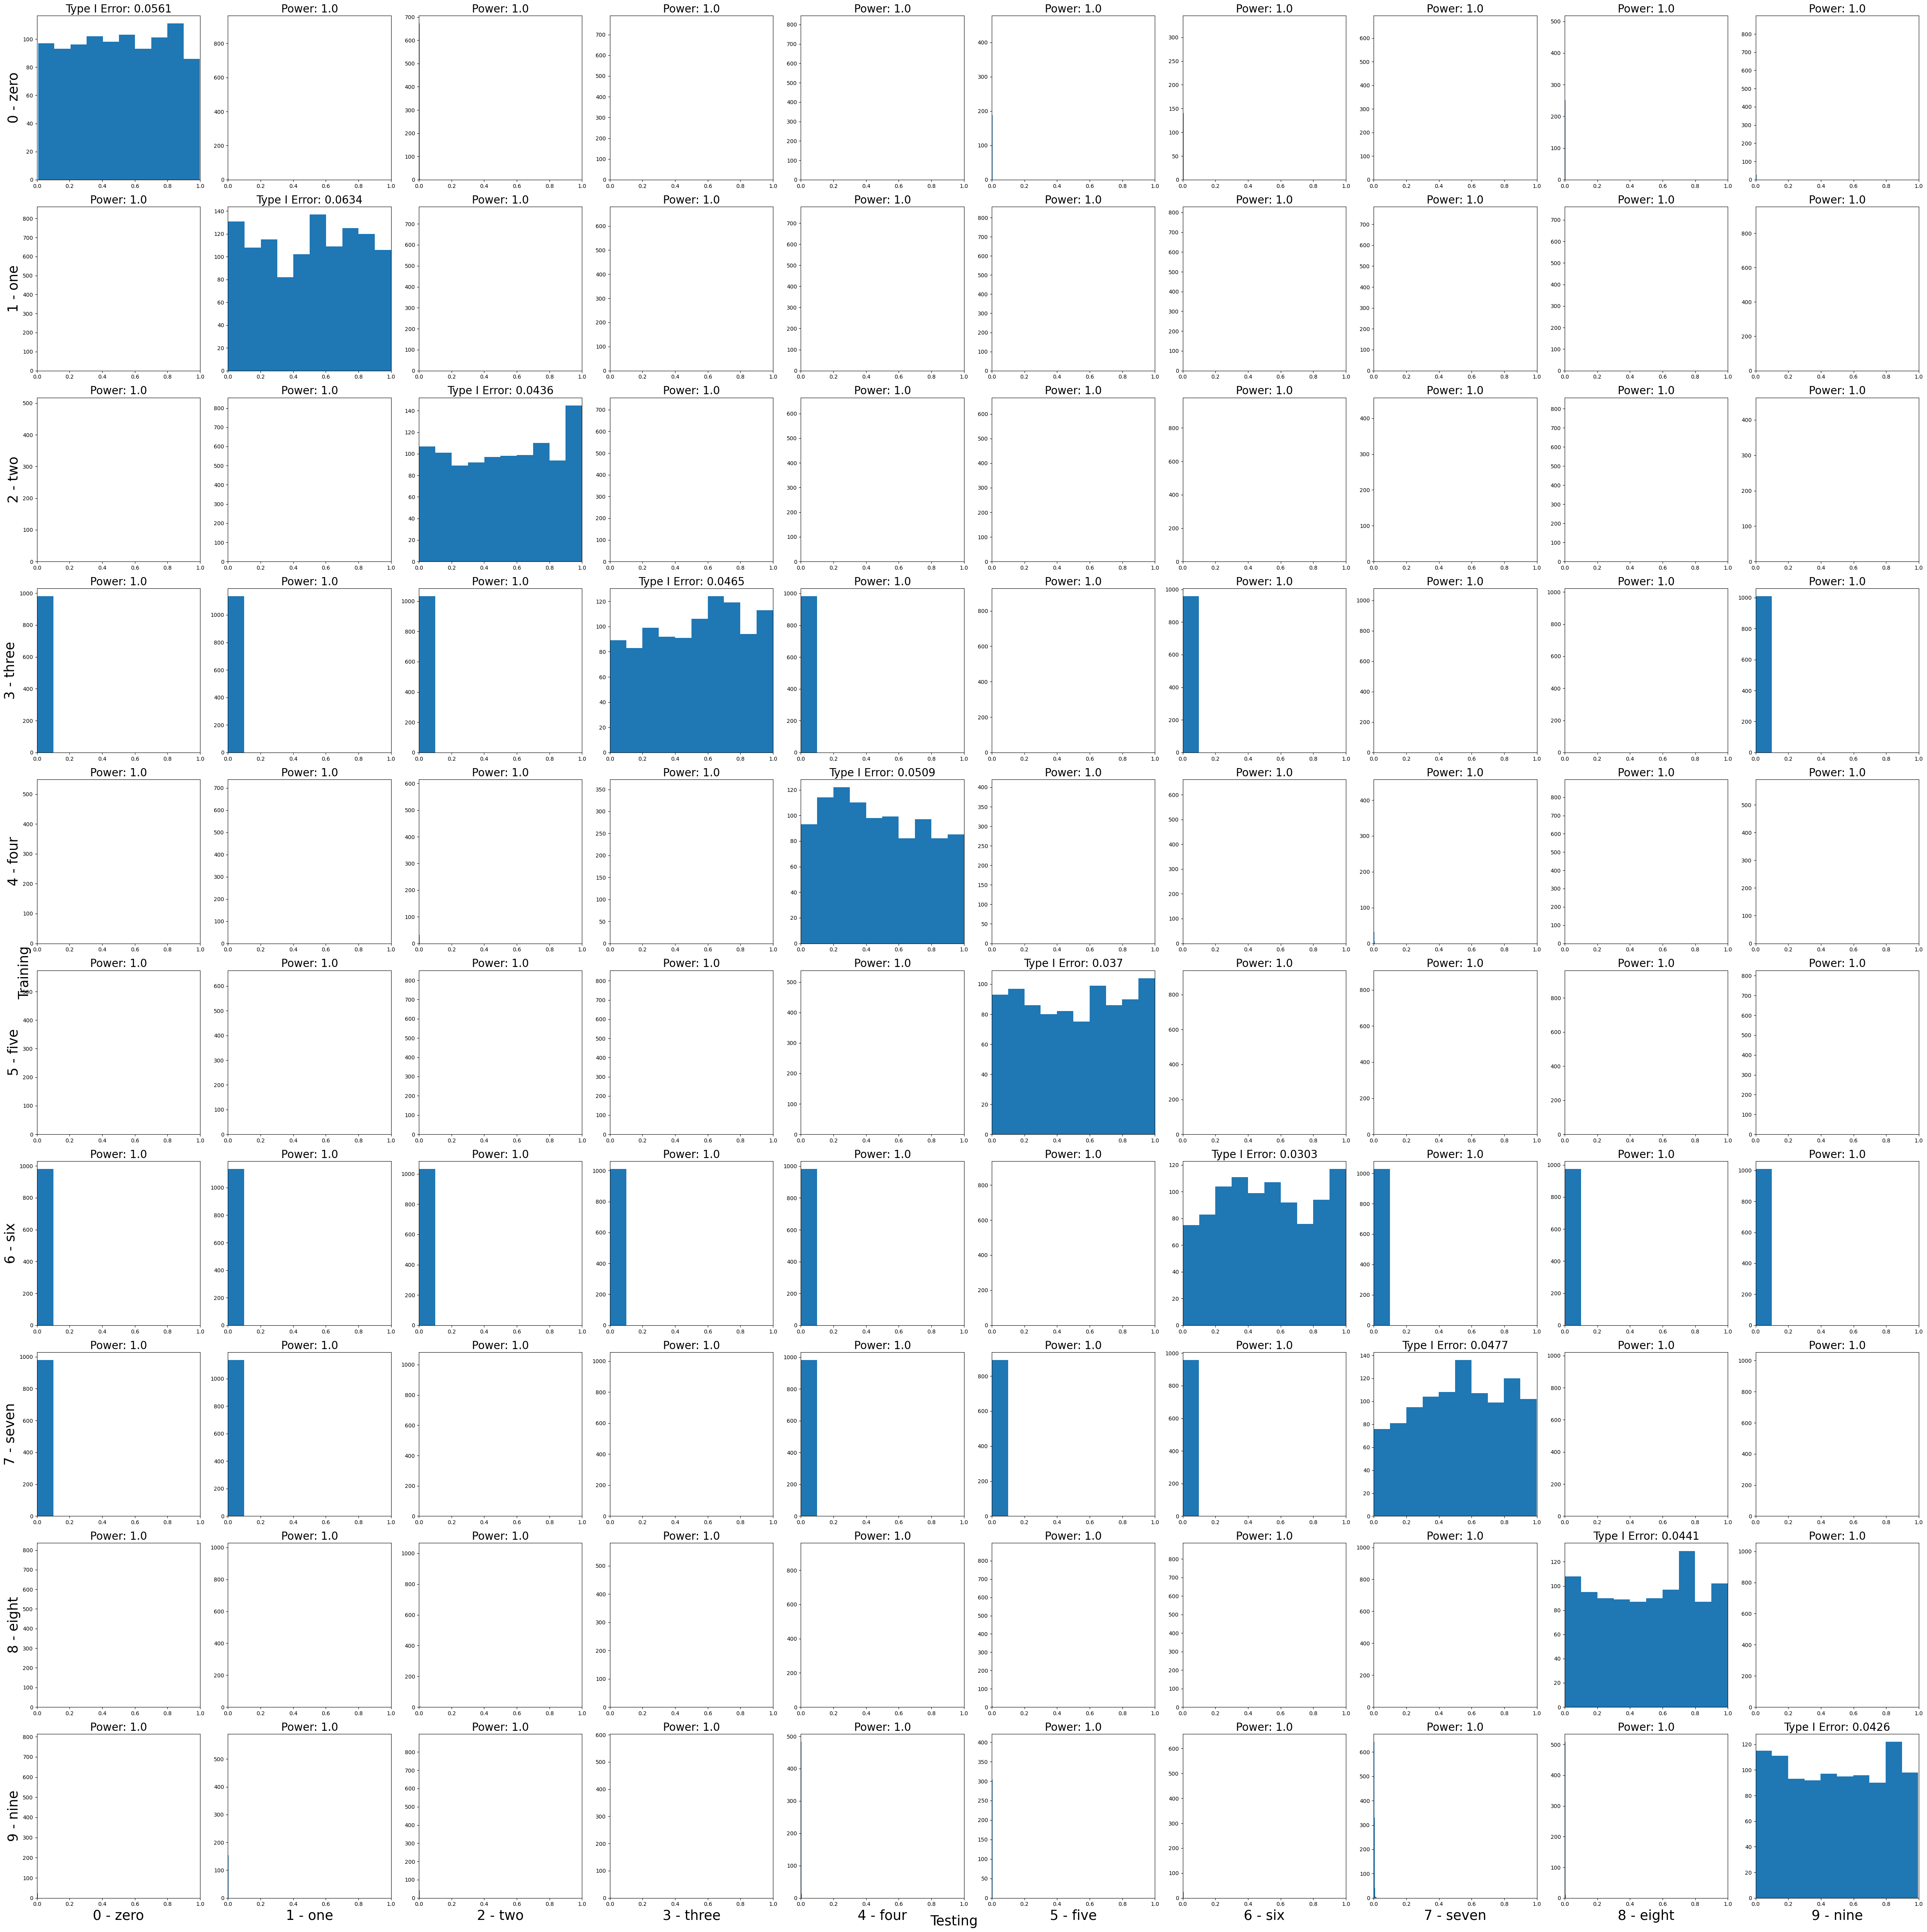

In [8]:
# visualize_p(all_p_vals, present_label, all_label, missing_label, z_dim, classes)

In [9]:
cover_accs = []
avg_counts = []

cover_acc = torch.zeros(len(all_label))
avg_count = torch.zeros(len(all_label))
for i, lab in enumerate(all_label):
    p_vals = all_p_vals[i]
    n = p_vals.shape[1]
    cover = 0.0
    counts = 0.0
    for j in range(n):
        pred = np.argmax(p_vals[:, j])
        p_set = np.where(p_vals[:, j] > 0.05)[0]
        counts += len(p_set)
        if lab in missing_label:
            if len(p_set) == 0:
                cover += 1
        else:
            if all_label[i] in p_set:
                cover += 1
    cover_acc[i] = cover / n
    avg_count[i] = counts / n
cover_accs.append(cover_acc)
avg_counts.append(avg_count)

In [10]:
cover_acc = torch.zeros(len(all_label))
avg_count = torch.zeros(len(all_label))
for i, lab in enumerate(all_label):
    p_vals = all_p_vals[i]
    n = p_vals.shape[1]
    cover = 0.0
    counts = 0.0
    for j in range(n):
        ## sort the p value list and get the corresponding indicies
        sorted = -np.sort(-p_vals[:, j])
        indicies = np.argsort(-p_vals[:, j])
        if sorted[0] == 0:
            p_set = np.array([])
        else:
            ## find the minimum index when the coverage first exceeds 1-alpha
            idx = np.argmax(np.cumsum(sorted) / np.sum(sorted) > 0.95)
            p_set = indicies[:idx + 1]
            counts += len(p_set)
        if lab in missing_label:
            if len(p_set) == 0:
                cover += 1
        else:
            if lab in p_set:
                cover += 1
    cover_acc[i] = cover / n
    avg_count[i] = counts / n
cover_accs.append(cover_acc)
avg_counts.append(avg_count)

In [11]:
cover_acc = torch.zeros(len(all_label))
avg_count = torch.zeros(len(all_label))
for i, lab in enumerate(all_label):
    p_vals = all_p_vals[i]
    n = p_vals.shape[1]
    cover = 0.0
    counts = 0.0
    for j in range(n):
        ## sort the p value list and get the corresponding indicies
        sorted = -np.sort(-p_vals[:, j])
        sorted_norm = sorted / np.sum(sorted)
        indicies = np.argsort(-p_vals[:, j])
        
        if sorted[0] == 0:
            p_set = np.array([])
        else: 
            ## find the minimum index when the coverage first exceeds 1-alpha
            sorted_norm_cumsum = np.cumsum(sorted_norm)
            idx = np.argmax(sorted_norm_cumsum > 0.95)
            if idx != 0:
                gamma = (0.95 - sorted_norm_cumsum[idx - 1]) / sorted_norm[idx]
            else: 
                gamma = 0.95 / sorted_norm[idx]
            if np.random.rand(1) < gamma:
                p_set = indicies[:idx + 1]
            else: 
                p_set = indicies[:idx]
        counts += len(p_set)
        if lab in missing_label:
            if len(p_set) == 0:
                cover += 1
        else:
            if lab in p_set:
                cover += 1
    cover_acc[i] = cover / n
    avg_count[i] = counts / n
cover_accs.append(cover_acc)
avg_counts.append(avg_count)

In [12]:
print(cover_accs)
print(avg_counts)

[tensor([0.9439, 0.9366, 0.9564, 0.9535, 0.9491, 0.9630, 0.9697, 0.9523, 0.9559,
        0.9574]), tensor([1.0000, 1.0000, 1.0000, 0.9990, 0.9949, 0.9978, 0.9990, 0.9971, 0.9990,
        0.9970]), tensor([0.9990, 0.9692, 0.9971, 0.9990, 0.9929, 0.9955, 0.9969, 0.9961, 0.9990,
        0.9960])]
[tensor([0.9439, 0.9366, 0.9564, 0.9535, 0.9491, 0.9630, 0.9697, 0.9523, 0.9559,
        0.9574]), tensor([1.8867, 1.4687, 1.9574, 2.0079, 1.9776, 2.0717, 2.0658, 2.1265, 2.1057,
        1.9177]), tensor([1.5020, 1.3427, 1.5756, 1.6030, 1.6059, 1.6726, 1.6503, 1.6858, 1.6735,
        1.5659])]
